In this notebook, we replicate the analysis of notebook 14 for synthetic graphs generated using the `digress` method instead of `graphrnn`.

We find the following:

???

In [1]:
import pickle
import numpy as np
import networkx as nx
import os
import pickle

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

Load the training datasets (numbered 11 to 20).

In [3]:
training_graphs = {}
for i in range(11, 20):
    with open(f'deezer_ego_nets/split/deezer_edge_lists_100_nodes_set_{i}.pkl', 'rb') as ff:
        training_graphs[i-10] = [nx.from_edgelist(l) for l in pickle.load(ff)]
#     print(len(training_graphs[i-10]))

Load a (disjoint?) test dataset.

In [4]:
with open('deezer_subset_test.pkl', 'rb') as ff:
    test = pickle.load(ff)

In [5]:
testing_graphs = [nx.from_edgelist(l) for l in test]

Load synthetic datasets.

In [6]:
synthetic_graphs = {}

In [7]:
for i in range(1, 10):
    filename = f'digress/set{i}_generated_adjs.npz'
    print(f'Loading {filename}...')
    # Code from Praveen.
    loaded_data = np.load(filename)
    loaded_adjacency_matrices = [loaded_data[key] for key in loaded_data]
    loaded_networkx_graphs = [nx.from_numpy_array(adj_matrix) for adj_matrix in loaded_adjacency_matrices]
    synthetic_graphs[i] = loaded_networkx_graphs
    print(f'Loaded {len(loaded_networkx_graphs)} graphs.')

Loading digress/set1_generated_adjs.npz...
Loaded 512 graphs.
Loading digress/set2_generated_adjs.npz...
Loaded 512 graphs.
Loading digress/set3_generated_adjs.npz...
Loaded 512 graphs.
Loading digress/set4_generated_adjs.npz...
Loaded 512 graphs.
Loading digress/set5_generated_adjs.npz...
Loaded 512 graphs.
Loading digress/set6_generated_adjs.npz...
Loaded 512 graphs.
Loading digress/set7_generated_adjs.npz...
Loaded 512 graphs.
Loading digress/set8_generated_adjs.npz...
Loaded 512 graphs.
Loading digress/set9_generated_adjs.npz...
Loaded 512 graphs.


Some plots to get an idea of representativity.

In [8]:
def summarize(training_graphs, synthetic_graphs, density=True):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist([len(g.nodes) for g in training_graphs], 20, facecolor='b', alpha=.5, density=density)
    plt.hist([len(g.nodes) for g in synthetic_graphs], 20, facecolor='g', alpha=.5, density=density)
    plt.title('Graph Size')
    plt.subplot(1, 2, 2)
    plt.hist([nx.density(g) for g in training_graphs], 20, facecolor='b', alpha=.5, density=density)
    plt.hist([nx.density(g) for g in synthetic_graphs], 20, facecolor='g', alpha=.5, density=density)
    plt.xlim([0,1])
    plt.title('Density')

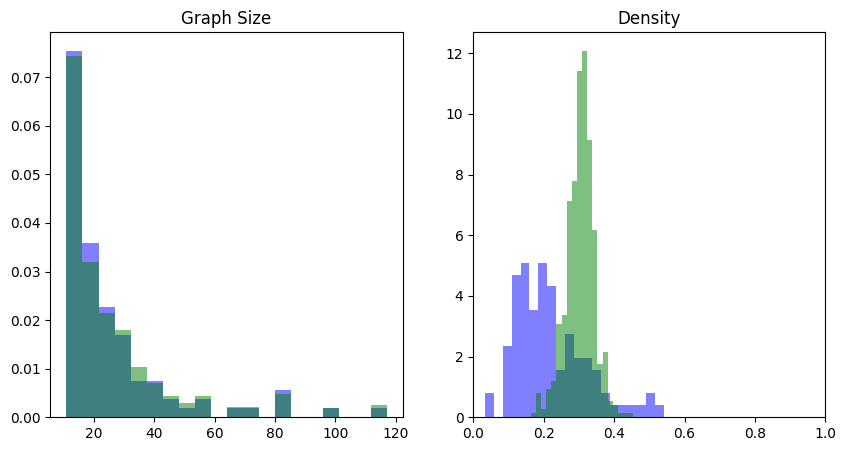

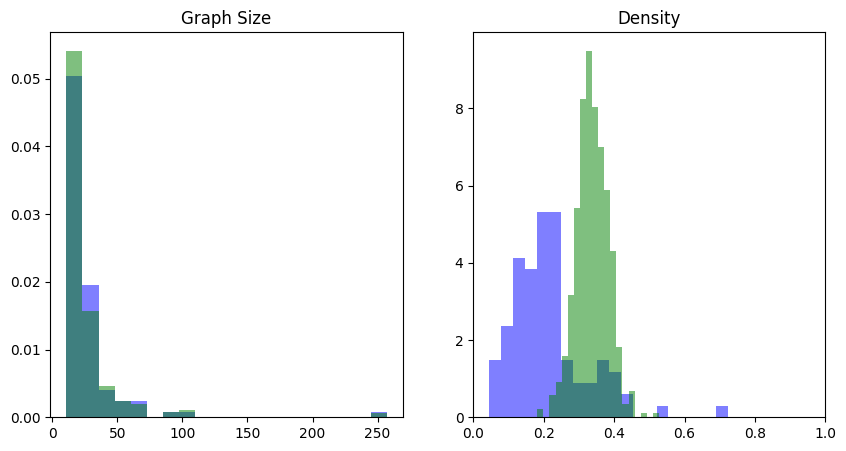

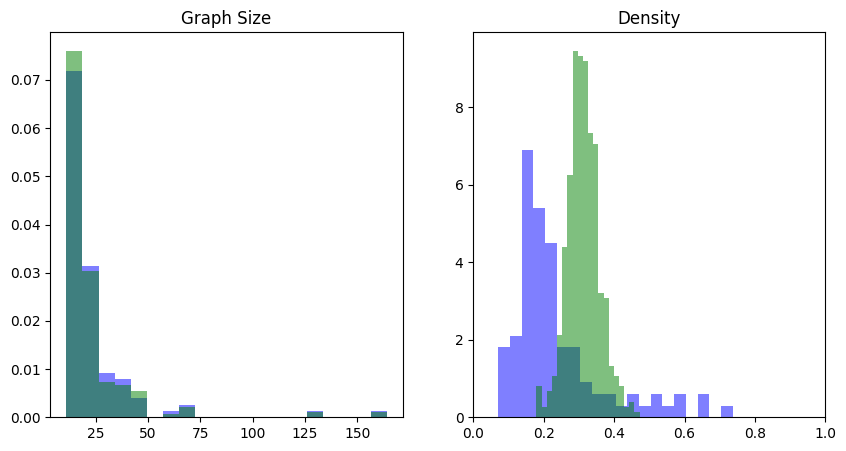

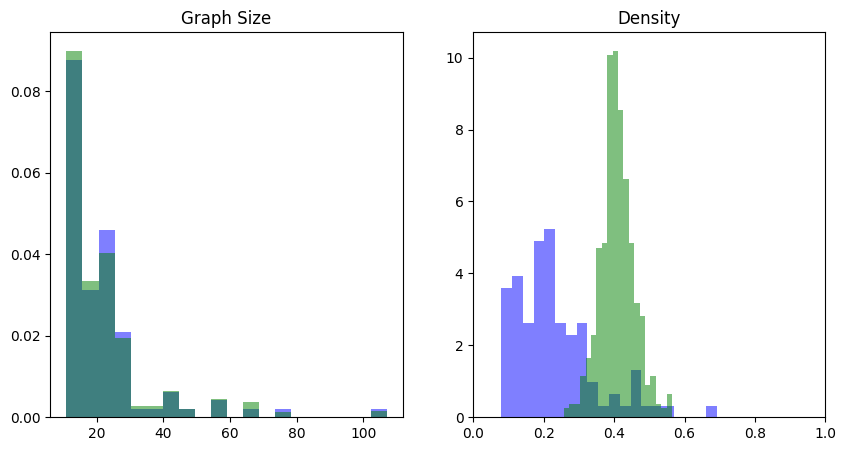

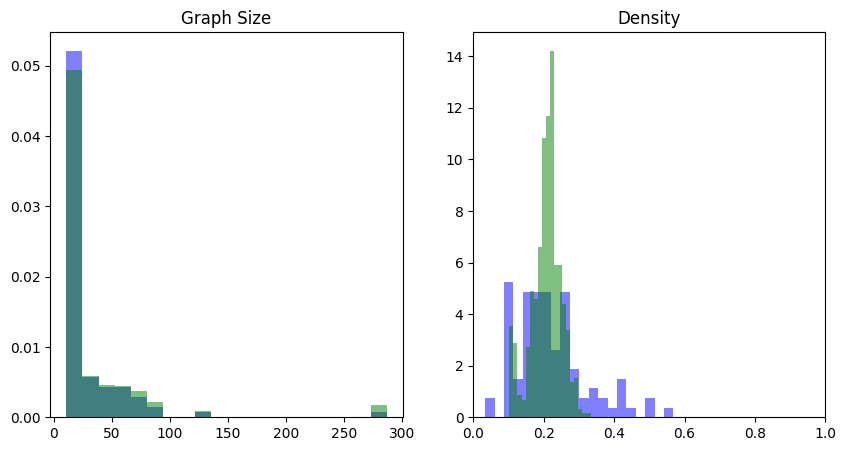

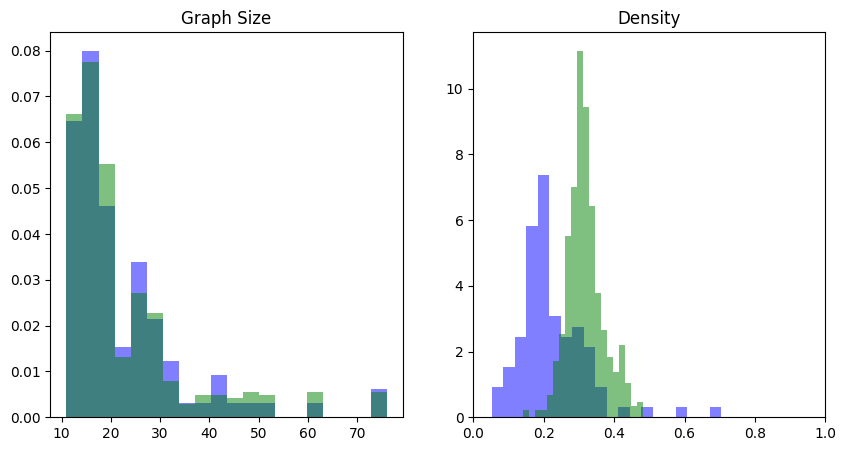

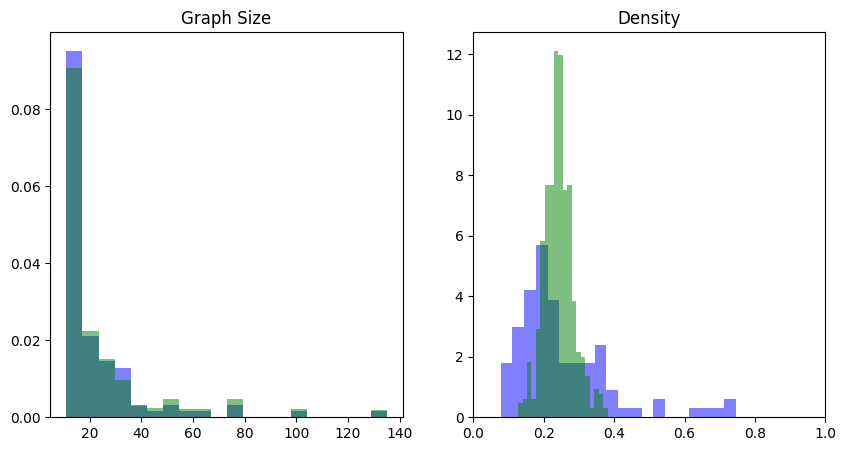

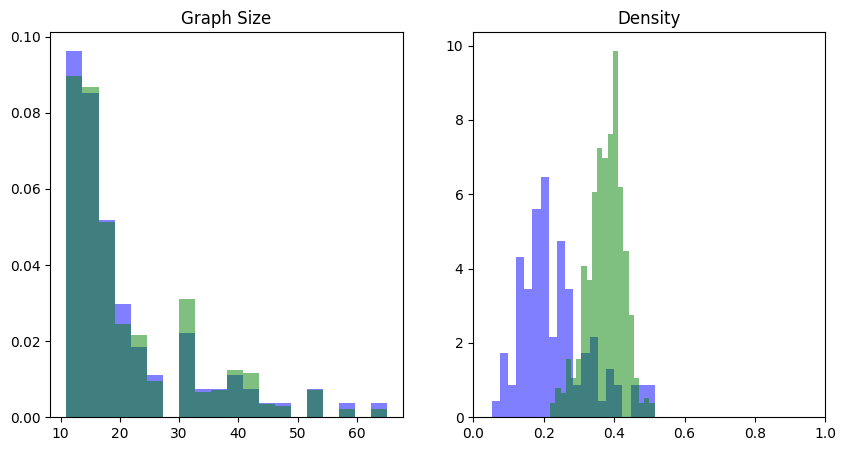

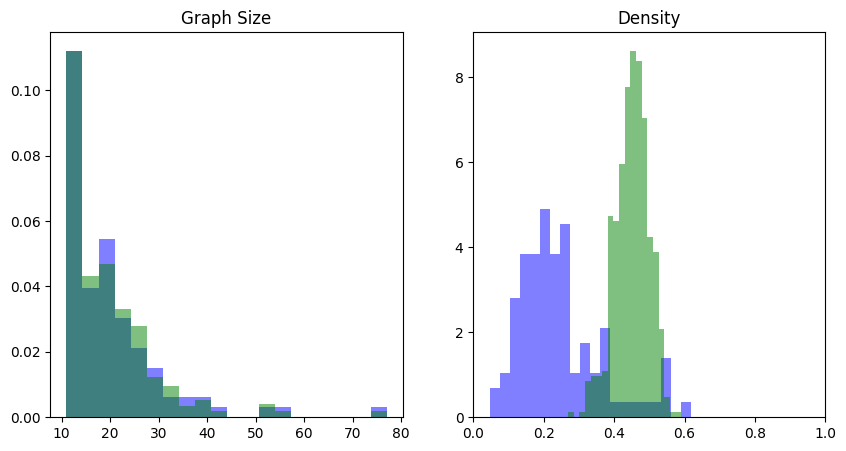

In [9]:
for i in range(1, 10):
    summarize(training_graphs[i], synthetic_graphs[i])

Kernel stuff.

In [10]:
import grakel
from grakel.utils import graph_from_networkx

def _grak(graphs):
    # Add a label to the graphs, for compatibility with grakel.
    for G in graphs:
        # Relabel the graph nodes (useful for the kernel).
        nx.set_node_attributes(G, dict(zip(G.nodes, range(len(G.nodes)))), "label")
    return graph_from_networkx(graphs, node_labels_tag="label")

In [11]:
from grakel import WeisfeilerLehman, VertexHistogram
# kernel = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)

Privacy evaluation: we will use the max-similarity (max-kernel) score, which doesn't require any training.

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score

In [13]:
def privacy_evaluation(synthetic_dataset, training_dataset, test_dataset):
    # Fit the kernel on the synthetic graphs.
    kernel = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)
    kernel.fit(_grak(synthetic_dataset))
    score_train = kernel.transform(_grak(training_dataset)).max(axis=1)
    score_test = kernel.transform(_grak(test_dataset)).max(axis=1)
#     score_train = np.percentile(kernel.transform(_grak(training_dataset)), 0.95, axis=1)
#     score_test = np.percentile(kernel.transform(_grak(test_dataset)), 0.95, axis=1)
    scores = np.concatenate((score_train, score_test))
    labels = np.array([1]*len(training_dataset) + [0]*len(test_dataset))
    plt.figure(figsize=(10, 5))
    print('AUC:', roc_auc_score(labels, scores))
    # ROC curve for these scores.
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(labels, scores)
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], 'k--', alpha=.1)
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    # Distributions of scores
    plt.subplot(1, 2, 2)
    bins = np.linspace(np.min(scores), np.max(scores), 21)
    plt.hist(score_train, bins, facecolor='g', alpha=.5, density=True)
    plt.hist(score_test, bins, facecolor='r', alpha=.5, density=True)

Safety check: if the synthetic graphs are the training graphs, this should have perfect accuracy. Note that this also verifies that the testing and training datasets are disjoint (not all of them are, but it doesn't really matter at this point in time).

AUC: 1.0
AUC: 0.995
AUC: 1.0
AUC: 0.995
AUC: 1.0
AUC: 1.0
AUC: 1.0
AUC: 1.0
AUC: 0.9849999999999999


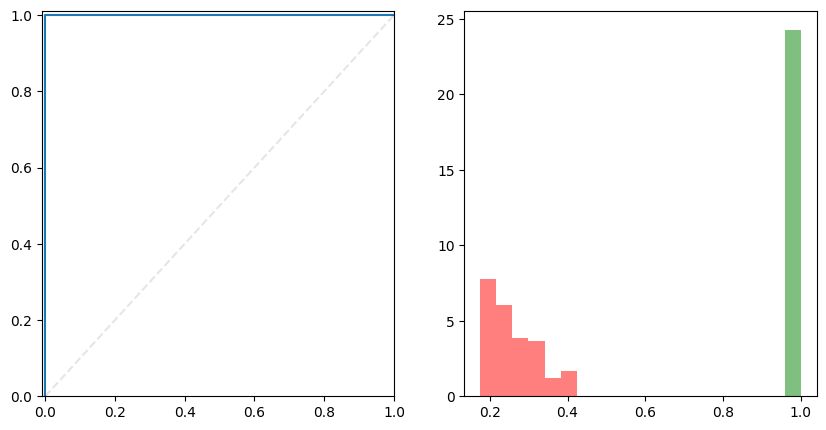

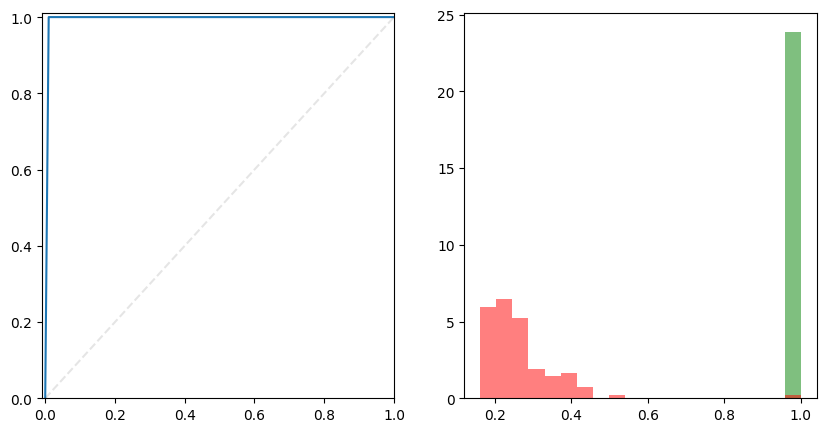

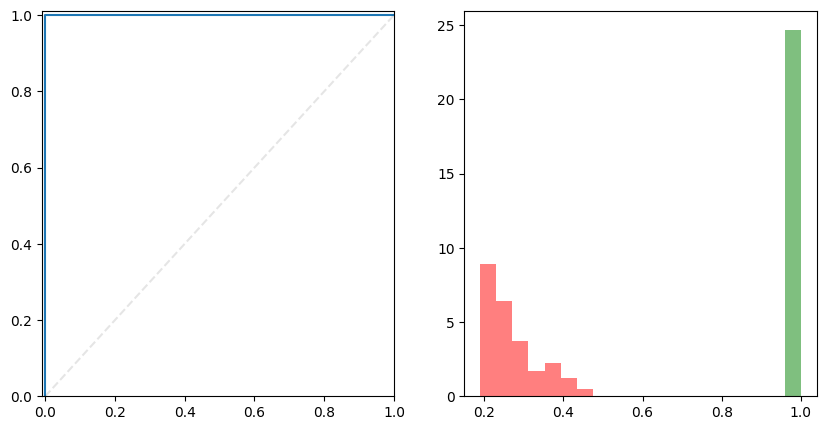

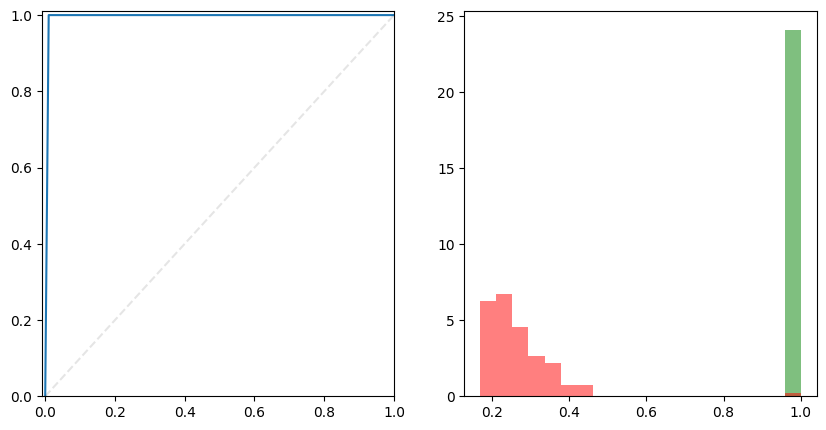

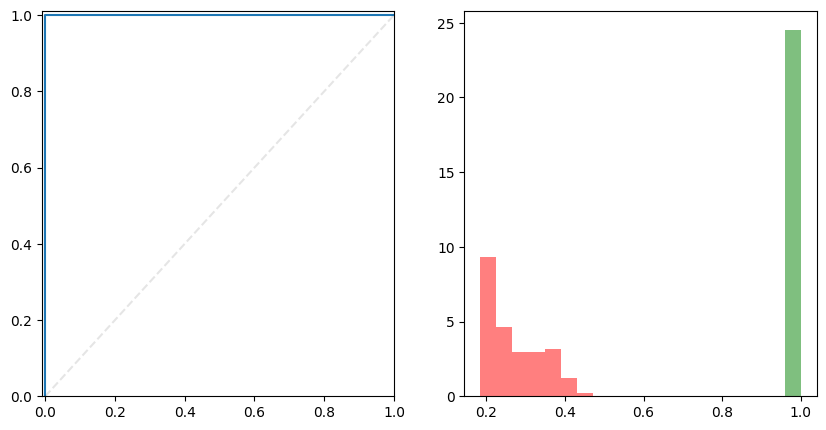

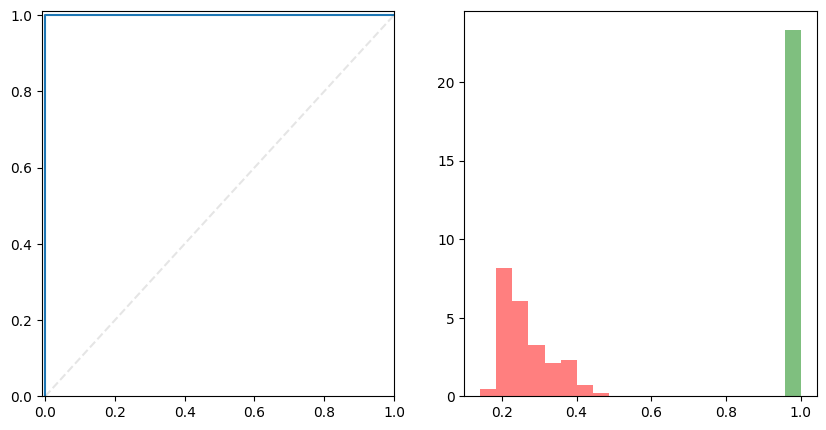

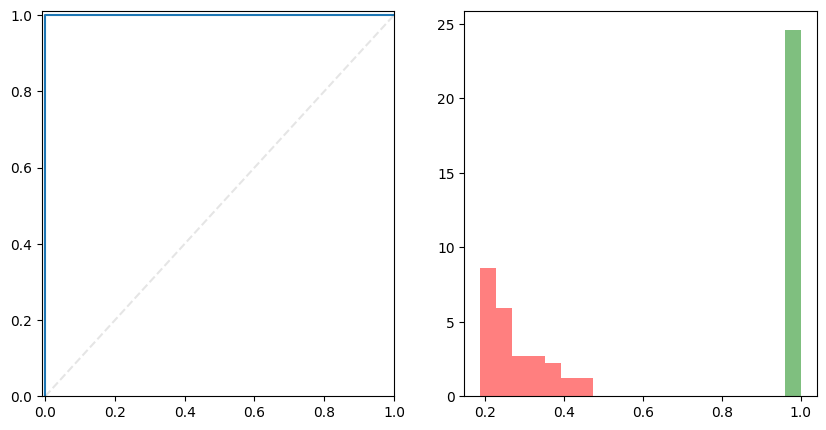

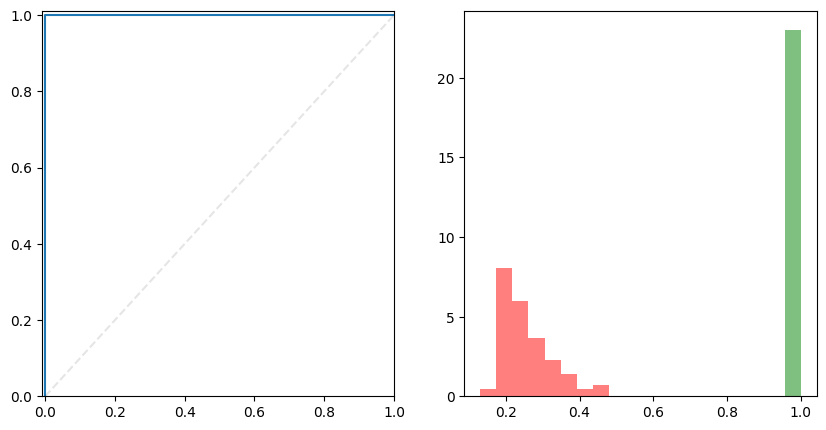

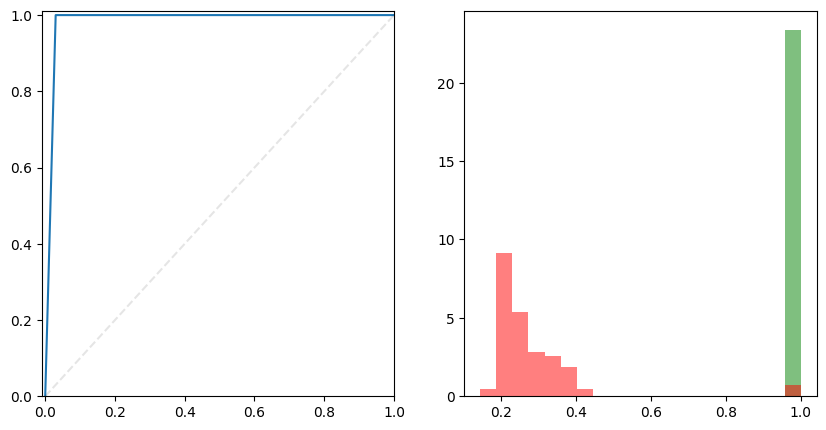

In [14]:
for i in range(1, 10):
    privacy_evaluation(training_graphs[i], training_graphs[i], testing_graphs)  # It does!

Moment of truth.

AUC: 0.50665
AUC: 0.5709
AUC: 0.57535
AUC: 0.5783999999999999
AUC: 0.54425
AUC: 0.55345
AUC: 0.6332500000000001
AUC: 0.57745
AUC: 0.56635


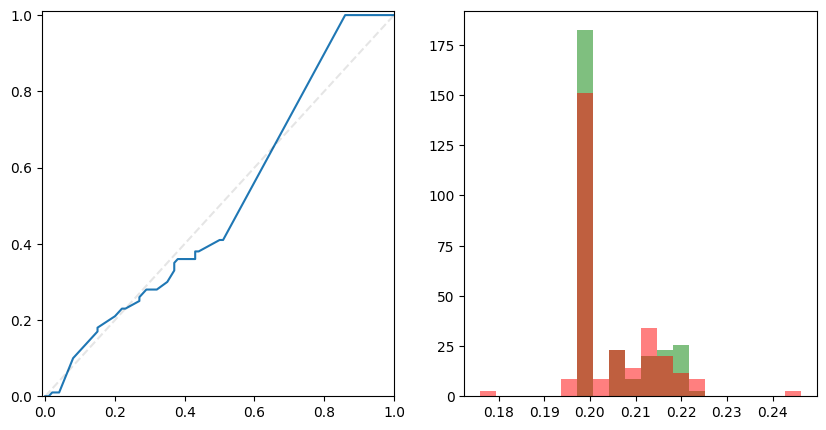

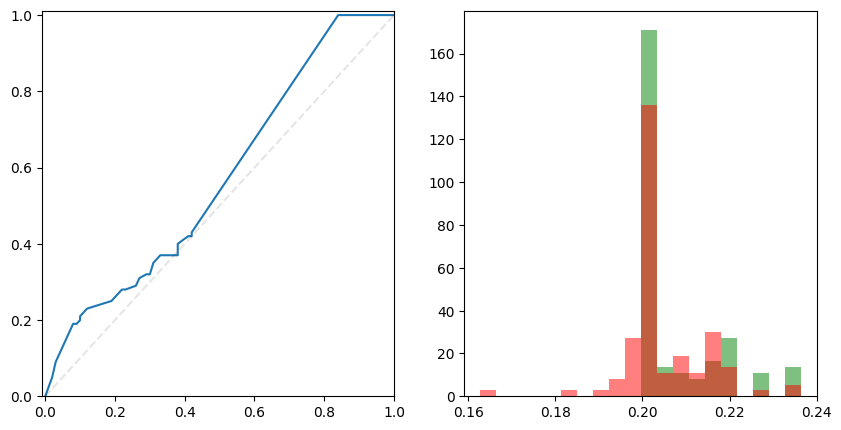

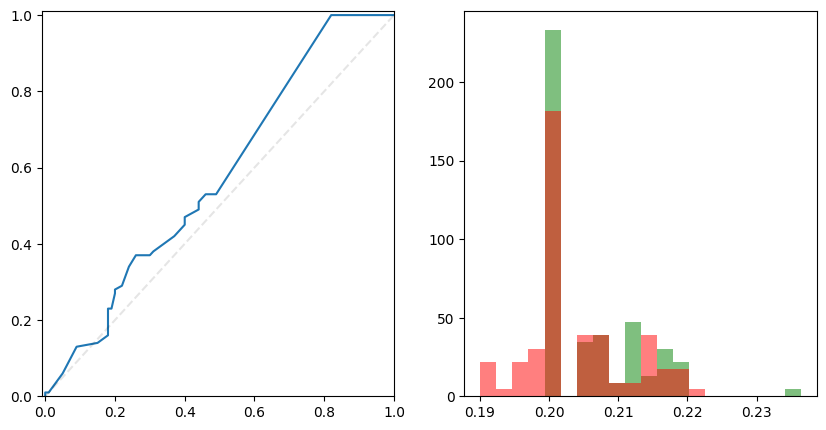

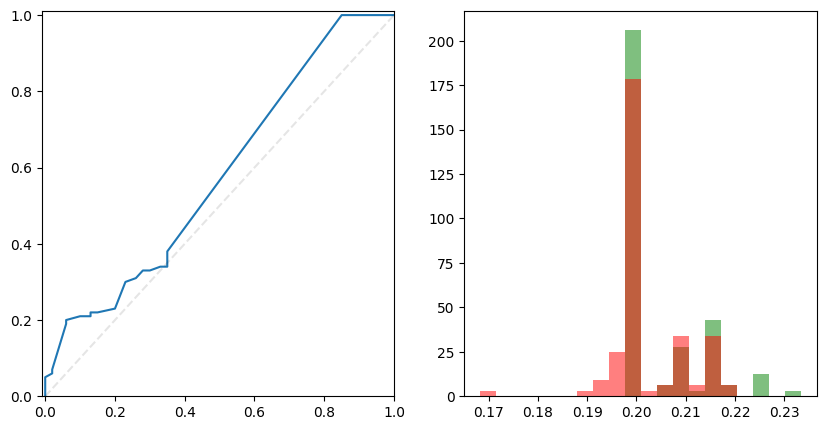

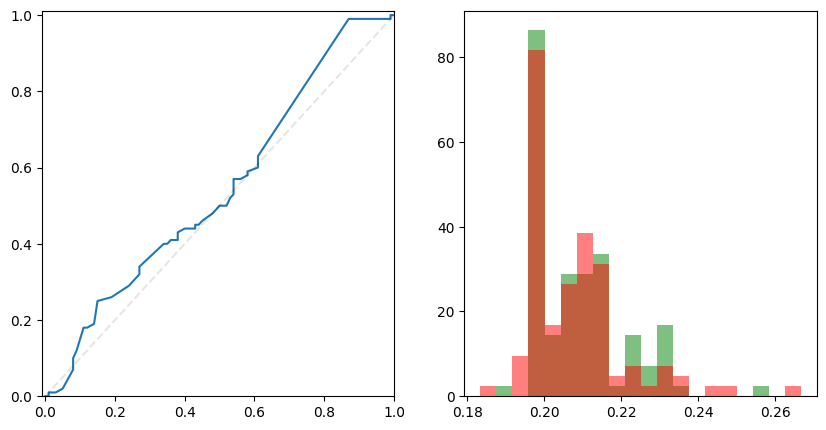

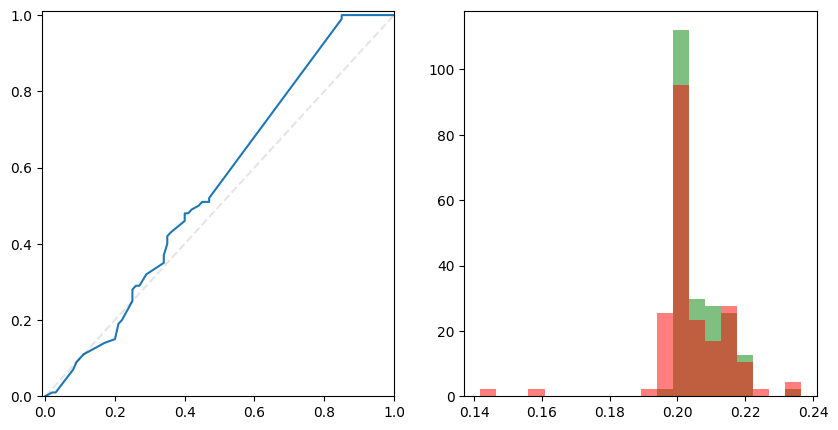

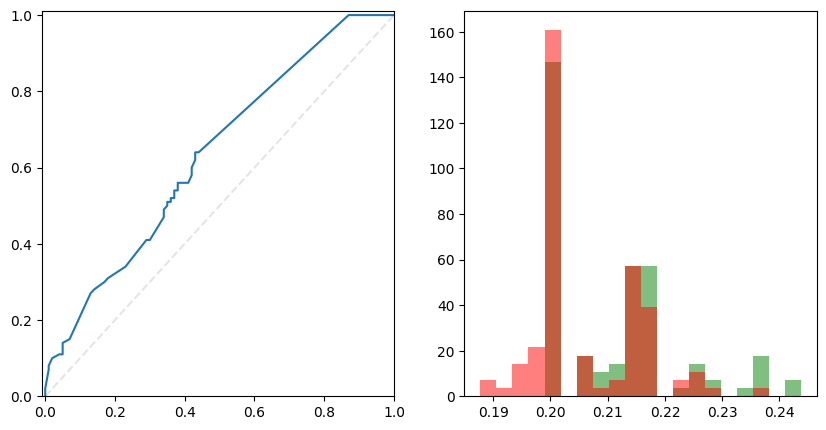

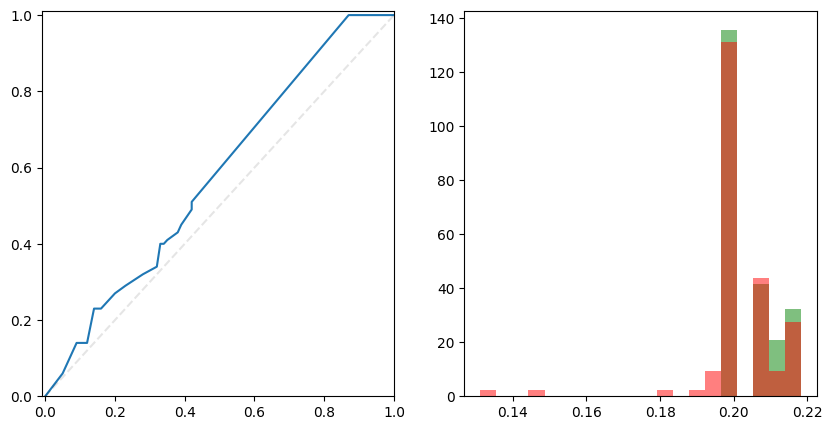

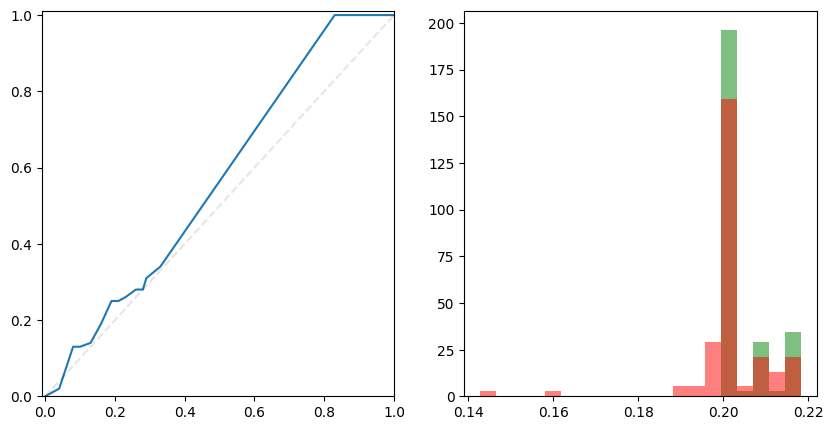

In [15]:
for i in range(1, 10):
    privacy_evaluation(synthetic_graphs[i], training_graphs[i], testing_graphs)

We can actually have a more robust negative sample size by taking all other sets as testing.

AUC: 0.47262499999999996
AUC: 0.52835
AUC: 0.5373187500000001
AUC: 0.5617374999999999
AUC: 0.5339625
AUC: 0.50884375
AUC: 0.5980375
AUC: 0.5640625
AUC: 0.5404875


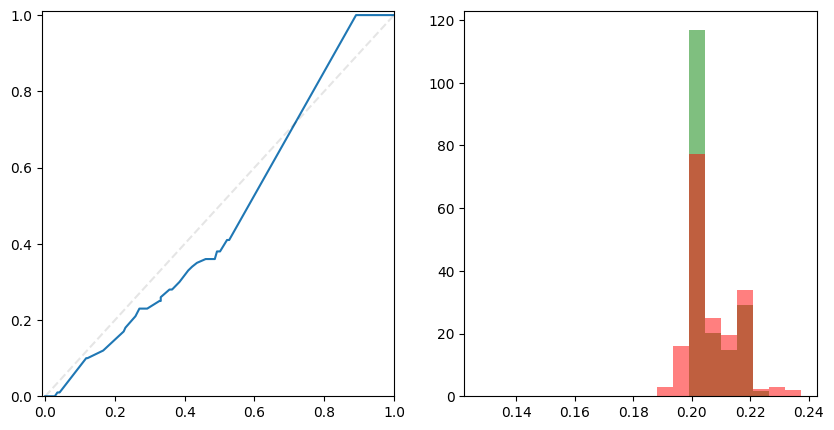

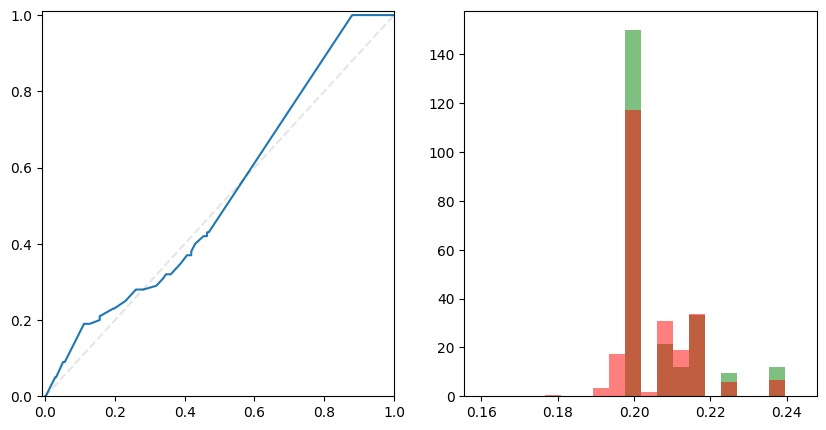

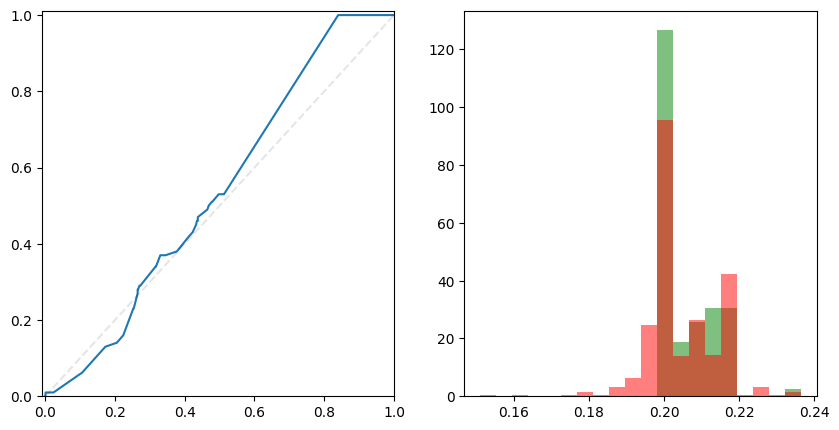

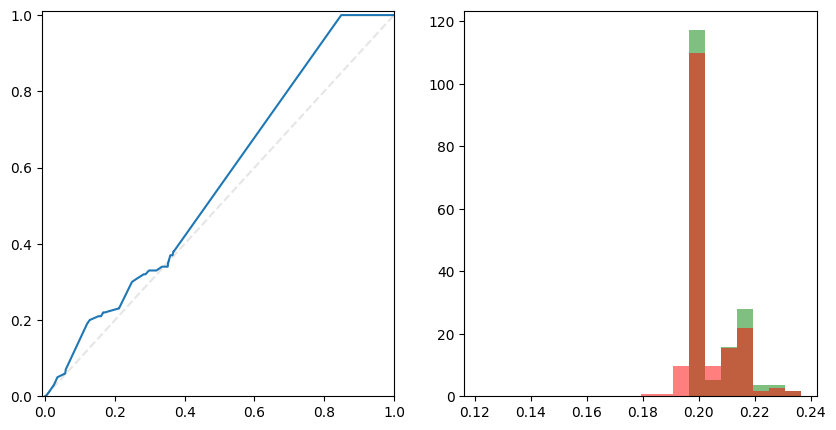

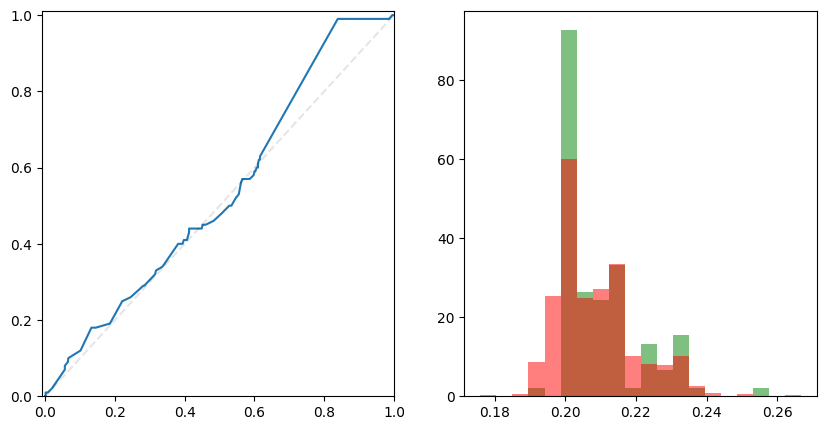

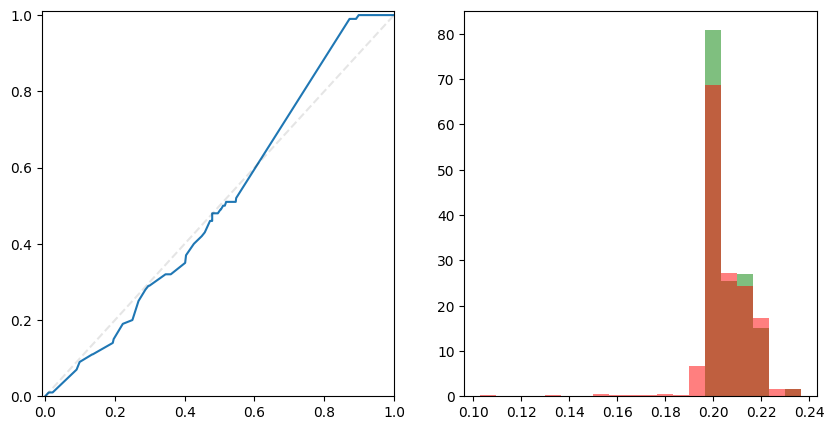

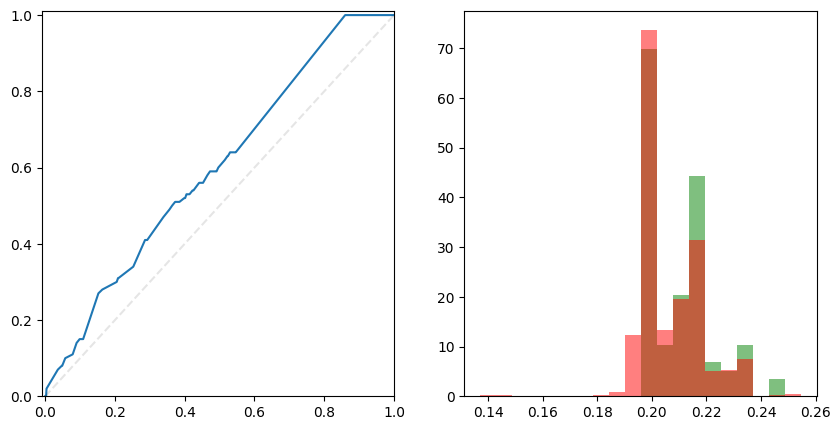

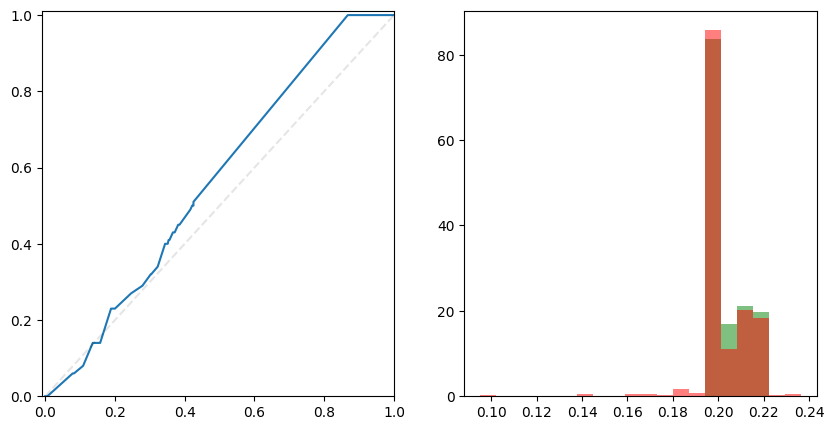

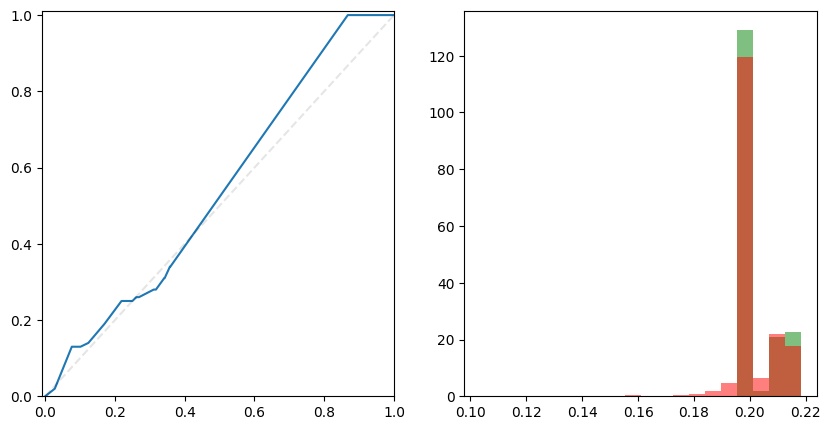

In [16]:
for i in range(1, 10):
    privacy_evaluation(
        synthetic_graphs[i],
        training_graphs[i],
        # Somewhat ugly code: concatenate all lists of testing graphs of different indices.
        sum([training_graphs[ii] for ii in range(1, 10) if ii != i], [])
    )

Additional study: the distribution of kernel values for graphs selected at random in and across sets.

In [17]:
def kernel_distro(dataset1, dataset2):
    kernel = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)
    s = kernel.fit_transform(_grak(dataset1))
    a1 = [s[i,j] for i, j in zip(*np.triu_indices(s.shape[0])) if i != j]
    s = kernel.fit_transform(_grak(dataset2))
    a2 = [s[i,j] for i, j in zip(*np.triu_indices(s.shape[0])) if i != j]
    kernel.fit(_grak(dataset1))
    s = kernel.transform(_grak(dataset2))
    # allow duplicate indices in the 
    a3 = [s[i,j] for i, j in zip(*np.triu_indices(s.shape[0], m=s.shape[1])) if i != j]
    bins = np.linspace(
        min(np.min(a1), np.min(a2), np.min(a3)),
        max(np.max(a1), np.max(a2), np.max(a3)),
        25
    )
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(a1, bins, facecolor='g', density=True)
    plt.title('Kernel of random synthetic graphs')
    plt.subplot(1, 3, 2)
    plt.title('Kernel of a synthetic and a training graph')
    plt.hist(a3, bins, facecolor=(0, 1, 1), density=True)
    plt.subplot(1, 3, 3)
    plt.title('Kernel of random training graphs')
    plt.hist(a2, bins, facecolor='b', density=True)

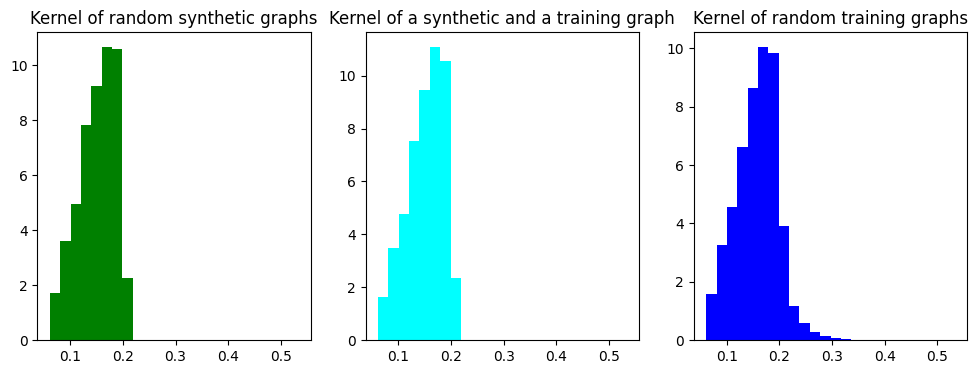

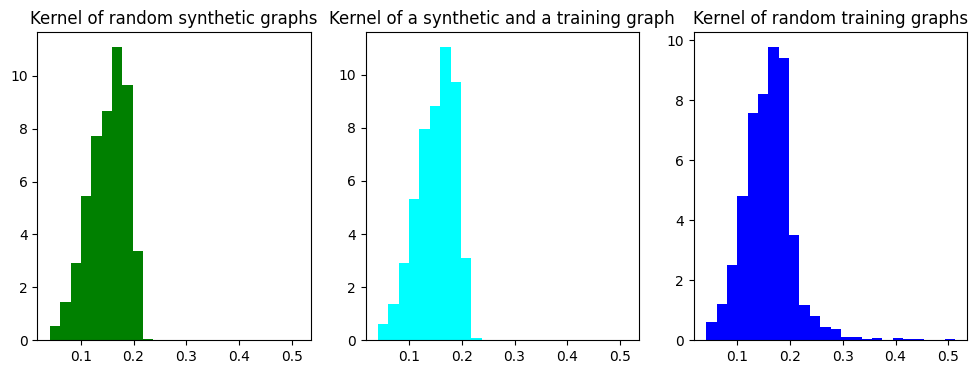

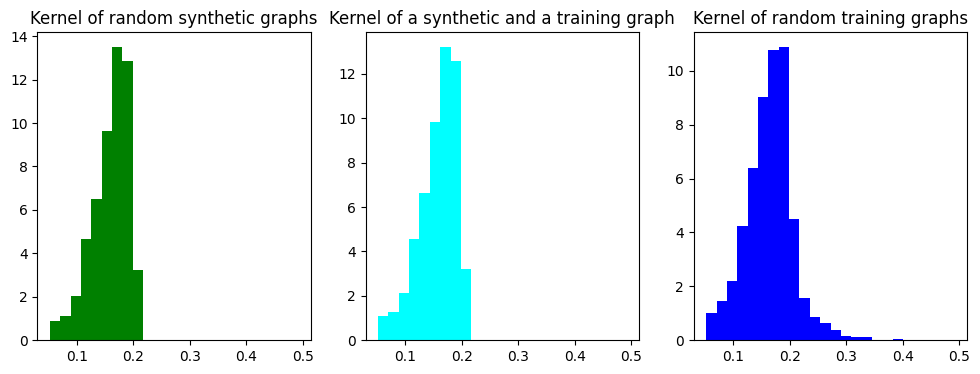

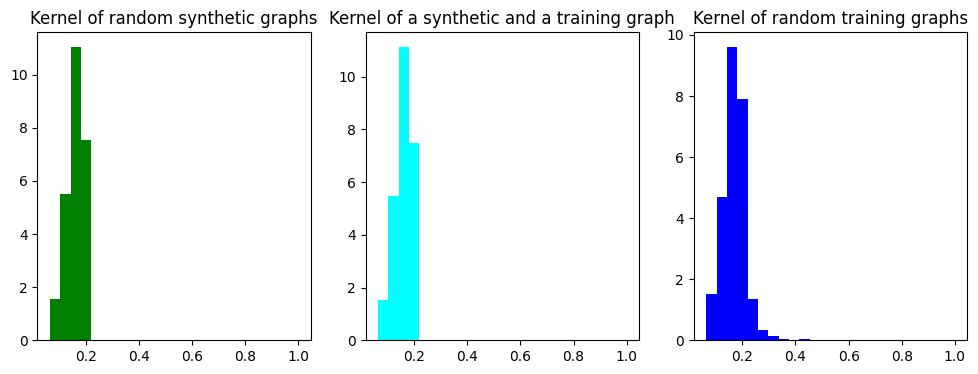

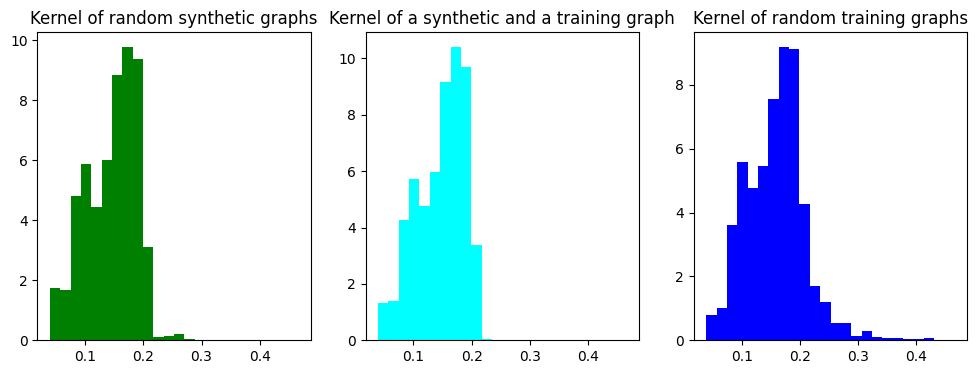

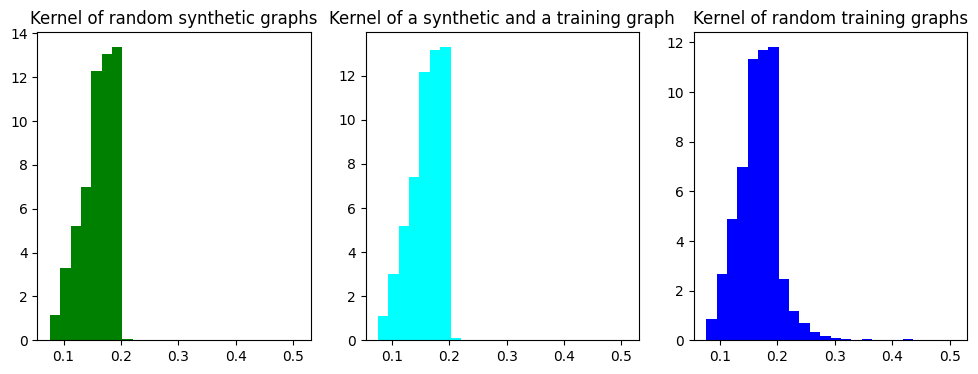

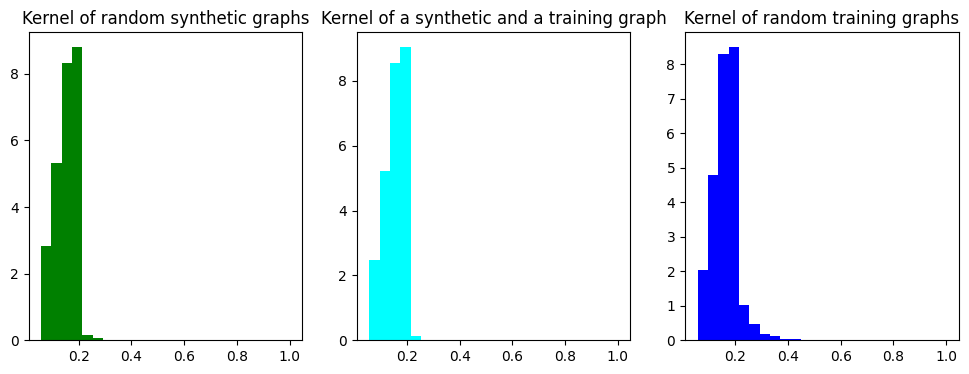

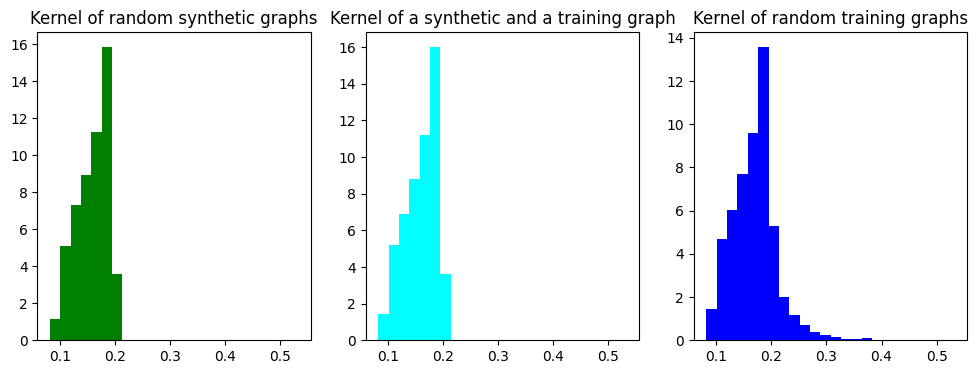

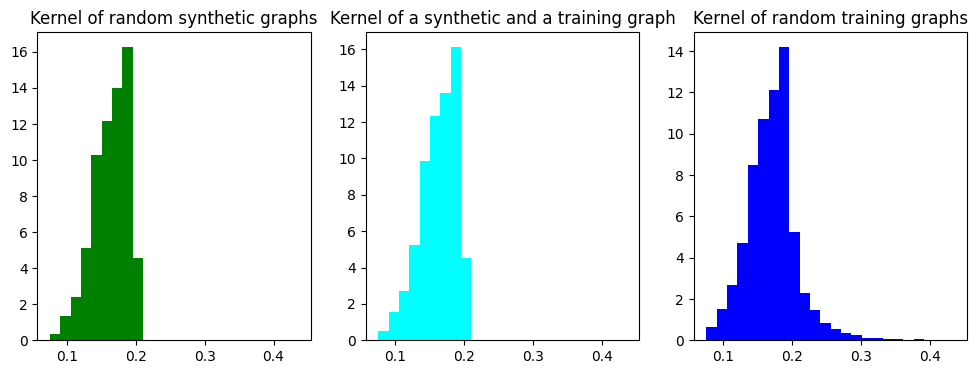

In [18]:
for i in range(1, 10):
    kernel_distro(synthetic_graphs[i], training_graphs[i])

## Post-analysis: who are these identifiable records?

As noted in the privacy analysis, it can be easy to identify whether specific records are _not_ in the dataset. Who are these records?


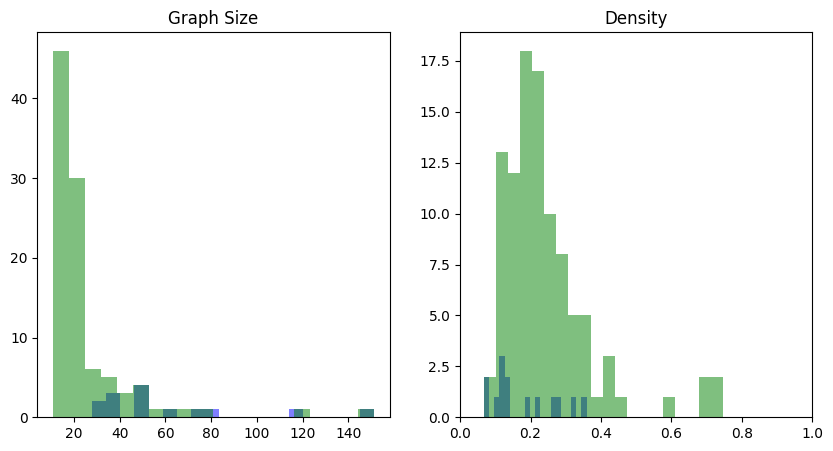

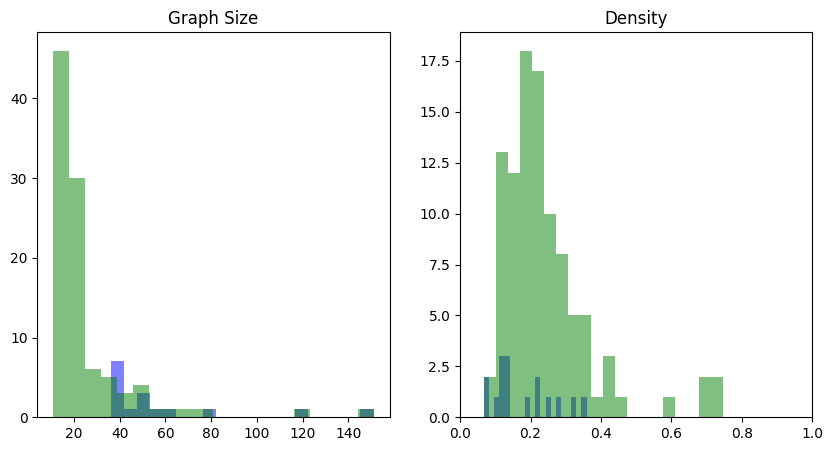

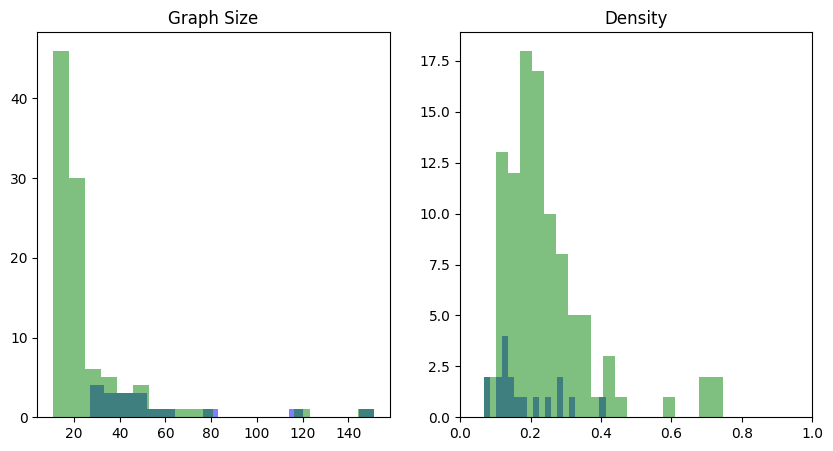

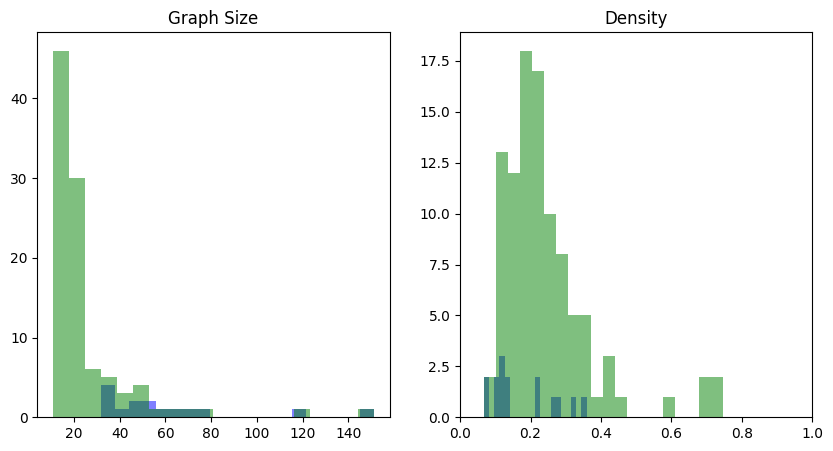

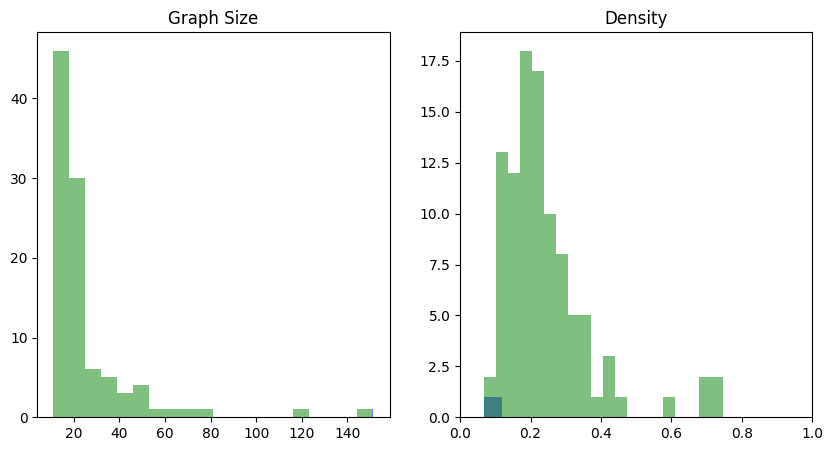

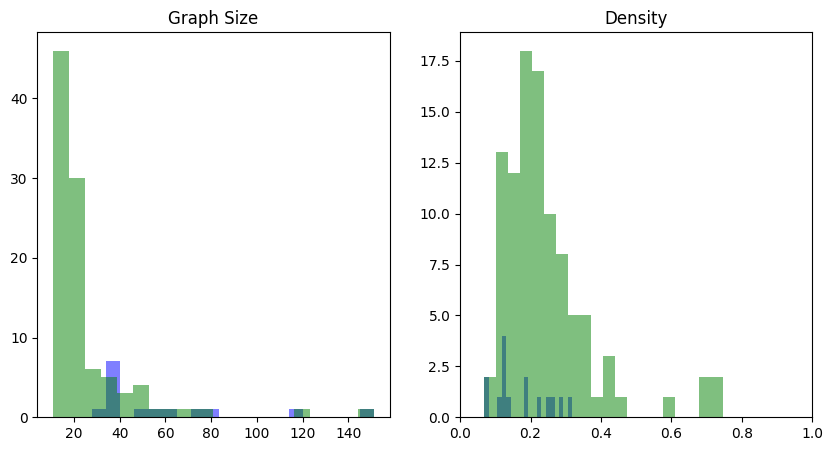

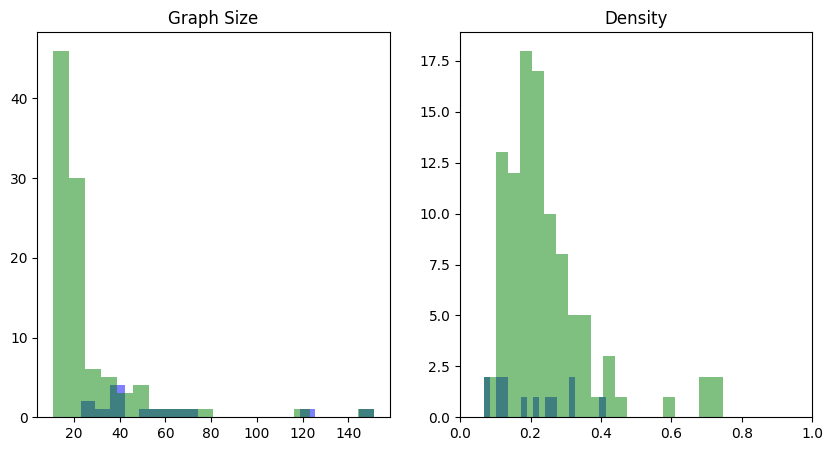

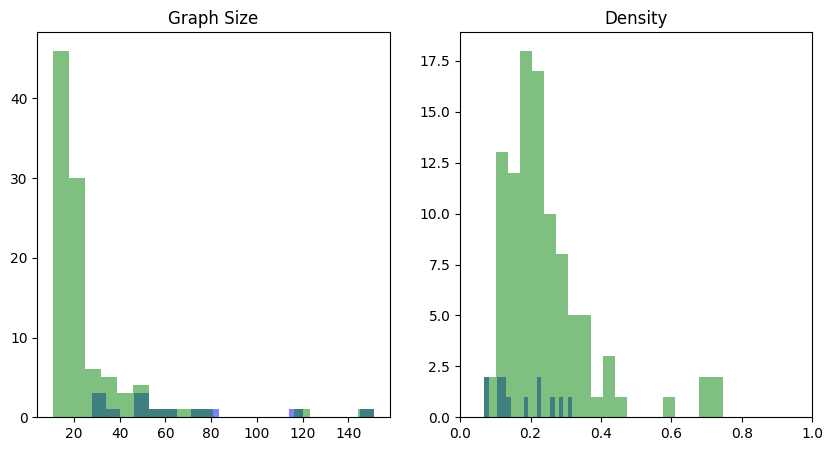

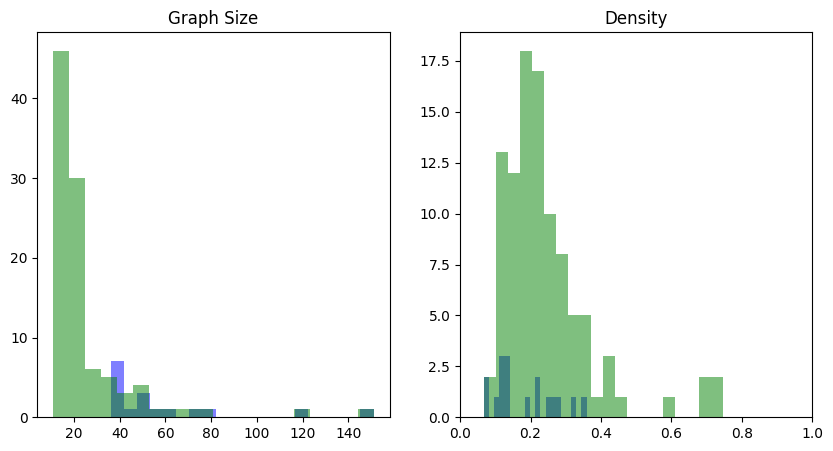

In [19]:
for i in range(1, 10):
    synth = synthetic_graphs[i]
    train = training_graphs[i]
    test = testing_graphs
    # Compute the scores.
    kernel = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)
    kernel.fit(_grak(synth))
    score_train = kernel.transform(_grak(train)).max(axis=1)
    score_test = kernel.transform(_grak(test)).max(axis=1)
    threshold = score_train.min()
    candidates = [g for s, g in zip(score_test, test) if s < threshold]
    # Candidates tend to be bigger graphs.
    summarize(candidates, test, density=False)

In [20]:
import collections

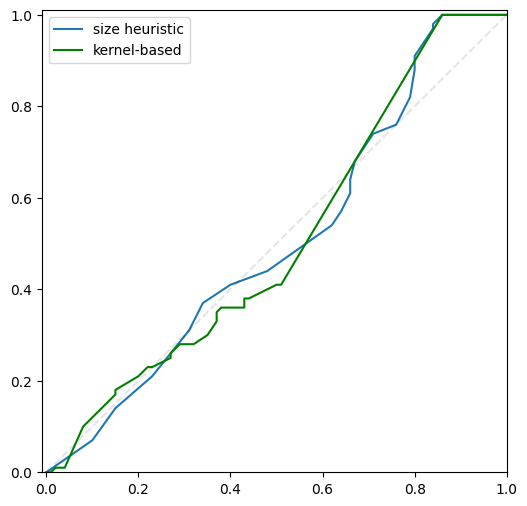

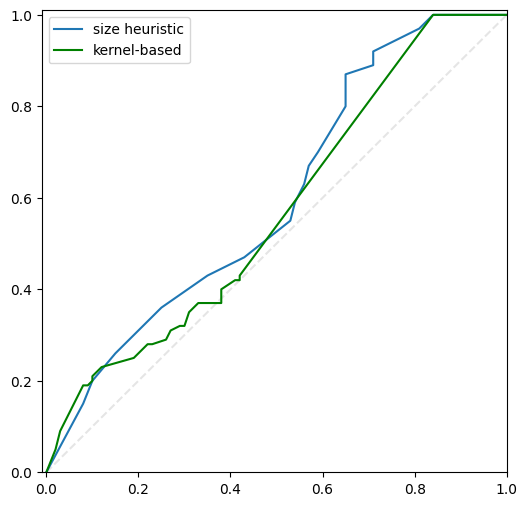

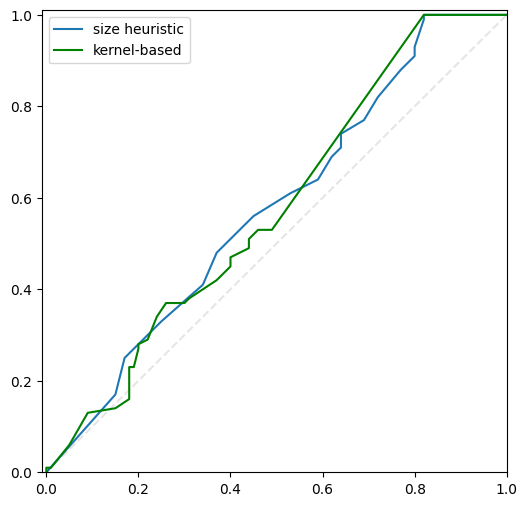

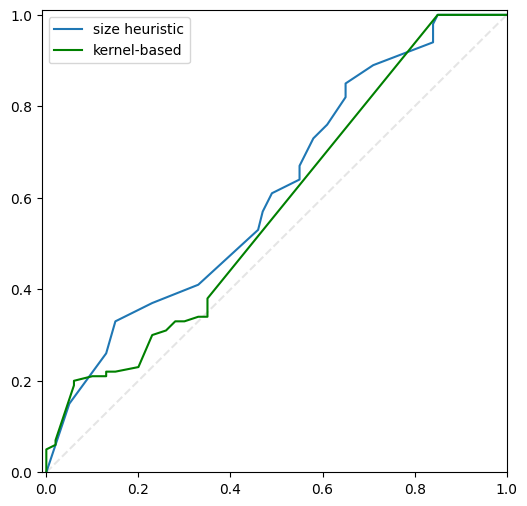

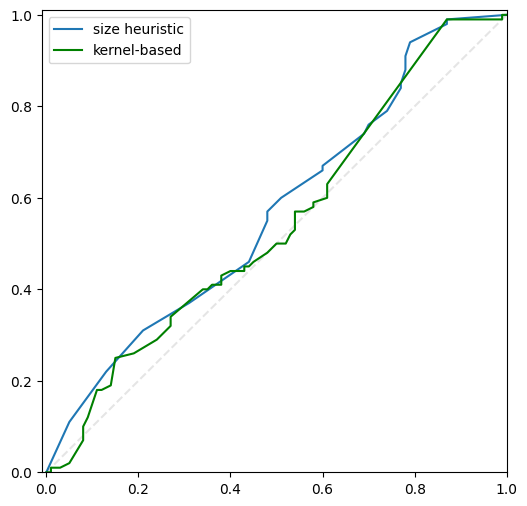

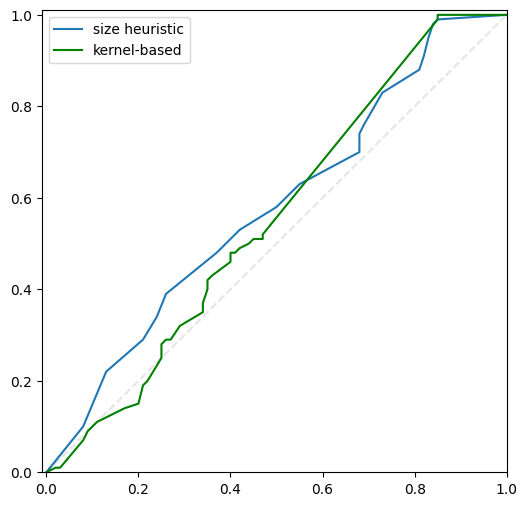

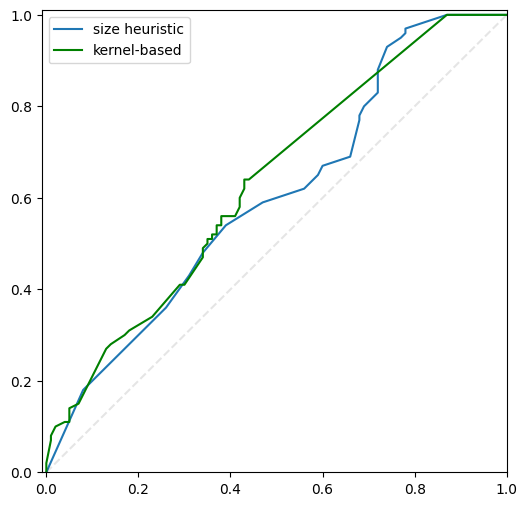

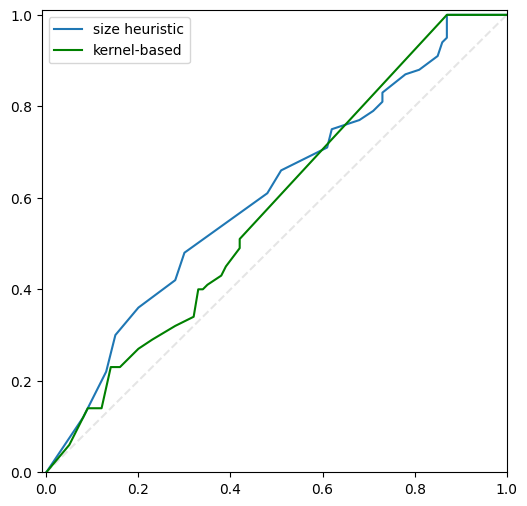

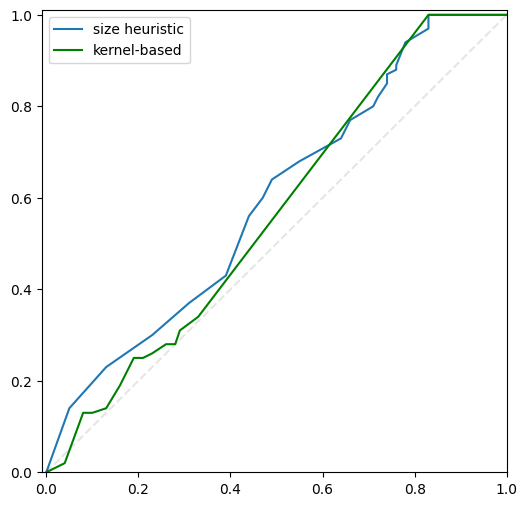

In [21]:
for i in range(1, 10):
    synth = synthetic_graphs[i]
    train = training_graphs[i]
    test = testing_graphs
    # Compute the scores.
    wc = collections.defaultdict(int)
    for g in synth:
        wc[len(g.nodes)] += 1
    score = lambda g: wc[len(g.nodes)]
    score_train = [score(g) for g in train]
    score_test = [score(g) for g in test]
    scores = np.concatenate((score_train, score_test))
    labels = np.array([1]*len(train) + [0]*len(test))
    plt.figure(figsize=(6,6))
    fpr, tpr, _ = roc_curve(labels, scores)
    plt.plot(fpr, tpr, label='size heuristic')
    plt.plot([0,1], [0,1], 'k--', alpha=.1)
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    kernel = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)
    kernel.fit(_grak(synth))
    score_train = kernel.transform(_grak(train)).max(axis=1)
    score_test = kernel.transform(_grak(test)).max(axis=1)
    scores = np.concatenate((score_train, score_test))
    # ROC curve for these scores.
    fpr, tpr, _ = roc_curve(labels, scores)
    plt.plot(fpr, tpr, 'g', label='kernel-based')
    plt.legend()